# Exploration of chemical pollution from a place based perspective

{bdg-link-info}`Notebook Repository <https://github.com/NERC-CEH/ds-toolbox-notebook-EEX-placebased-exposure.git>`
{bdg-warning-line}`Ongoing Development`
![alt text](./images/ukceh-logo-badge.png "Title")

Primary Contact: [Dr. Michael Hollaway](https://www.ceh.ac.uk/staff/michael-hollaway)

````{card} Challenge:
When thinking about a particular place (E.g. a particular point, town, city or even a region), people often want to know more about the levels of pollution in that region in the present and often the past. This presents a significant challenge as there are multiple sources of pollution (e.g. air pollution or water pollution) and multiple providers/collectors of pollution data (e.g. the Environment Agency (EA) or the Department for Environment, Food and Rural Affairs (Defra)). In addition there are ever increasing volumes of data being collected from a variety of sensor types. If someone wants to answer the question of "I lived in the North East of England from 2000 to 2025, what sort of pollution was I exposed to?" a significant challenge is presented to extract, filter, aggregate and visualized the data in a meaningful way. The resultant workflow often requires different tools and technical skills to be able to answer the question. 
````

````{card} Approach:
This notebook presents a demonstration of one potential approach to addressing this challenge using examples of data from the Defra managed Automatic Urban and Rural Network ([AURN](https://uk-air.defra.gov.uk/networks/network-info?view=aurn)) and the EA managed Water quality Gas/Liquid Chromatography mass spectrometry ([GCMS/LCMS](https://www.data.gov.uk/dataset/0c63b33e-0e34-45bb-a779-16a8c3a4b3f7/water-quality-monitoring-data-gc-ms-and-lc-ms-semi-quantitative-screen)) datasets to represent air and water pollution respectively. Developed using the python coding language the code shows methods for choosing a particular place, extracting all the available data for that place, calculating the summary statistics for that region (including some simple data science methods to interpolate between measurement locations) and visualizing the final results. Finally functionality is provided to run the notebook as a dashboard allowing the user to interactively run the analysis over different places. 
````

```{admonition} Running the Notebook:
:class: tip, dropdown
To run the notebook it is advised to first clone the repository housing the notebook ('*git clone https://github.com/NERC-CEH/ds-toolbox-notebook-EEX-placebased-exposure.git*'). This will create a folder in the current directory called *ds-toolbox-notebook-EEX-placebased-exposure*, which holds all the relevant files including the notebook, environment file and relevant input data. The next step is to create a conda environment with the right packages installed using the complete yml file ('*conda env create -f environment_complete.yml*'), which creates the *EEX-placebased-exposure* environment that can be activated using '*conda activate EEX-placebased-exposure*'. At this point the user can either run code from the notebook in their preferred IDE or via the jupyter interface using the command '*jupyter notebook*'.
```

```{admonition} Generalisability:
:class: note, dropdown
The methods and processes demonstrated in this notebook should be transferable to other datasets beyond the air quality and water quality examples used here. These methods should be able to work with other point based datasets and the spatial filtering should work for other polygons. The workflow presented is designed to be a starter example for a potential method to investigate location specific chemical pollution and is setup to be easily built upon for more detailed analysis.   
```

```{admonition} Data Sources:
:class: note, dropdown
This notebook uses data from the following sources:

### Air Quality Data: Automatic Urban and Rural Network (AURN) 

A description of the AURN network is available from the [UK-AIR](https://uk-air.defra.gov.uk/networks/network-info?view=aurn)
website.The data are freely available to download and are provided by the Department for the Environment and Rural Affairs
(Defra) under the following attribution statement:

&copy; Crown copyright 2021 Defra via uk-air.defra.gov.uk, licensed under the [Open Government Licence](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)

### Water Quality Data: Water quality monitoring data GC-MS and LC-MS semi-quantitative screen

A description of the EA water quality GC-MS and LC-MS semi-quantitative screen data is available from the [data.gov.uk](https://www.gov.uk/government/publications/water-quality-monitoring-data-gc-ms-and-lc-ms-semi-quantitative-screen)

This dataset is licensed under the [Open Government Licence](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)

### UK Regional map data: Nomenclature of Territorial Units for Statistics (NUTS) Level 1

A description of the NUTS1 spatial dataset is available from the [Office for National Statistics Open Geography Portal](https://geoportal.statistics.gov.uk/datasets/da54eace6ebc43689367792ff4de39e0_0/explore)

- Source: Office for National Statistics licensed under the Open Government Licence v.3.0

- Contains OS data &copy; Crown copyright and database right 2018

This dataset is licensed under the [Open Government Licence](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)

```

```{admonition} Computational Demands
:class: warning, dropdown
It should be noted that whilst this notebook in its current form runs fairly quickly on a standard laptop computer, this is achieved by pre-processing the raw data files into parquet format and only demonstrating the functionality of the methods using fairly computationally light operations and on a relatively small dataset. Therefore the user should be aware that if they desire to bring in more complex or advanced analytical methods or larger datasets then the computational demand will likely increase and appropriate CPU/GPU time may be needed. 
```

```{contents}
:local:
```
<!-- https://jupyterbook.org/en/stable/structure/configure.html -->

## Introduction

As part of the National Capability for UK Challenges (NC-UK) Programme the UK Environmental Exposure (UK-EEX) Hub is being developed to make it easier to discover, process, analyze and visualize the wealth of data regarding environmental pressures, particularly in relation to chemical pollutants. This notebook presents an example of how to take a place based approach to such an analysis and is expected to form the basis of this research area within the UK-EEX Hub.

The first step is to import all of necessary python packages that we need to carry out the workflow presented in this notebook. These include standard data manipulation packages such as pandas, polars and numpy, geospatial packages such as geopandas (to perform spatial operations), data visualisation packages such as matplotlib, analytical packages such as scipy and finally some packages that enable the notebook to also be run as an interactive dashboard should the user wish to do so.  

In [1]:
import polars as pl
import pandas as pd
import holoviews as hv
import geoviews as gv
import geopandas as gpd
from cartopy import crs as ccrs
import numpy as np
from holoviews.streams import Selection1D
import panel as pn
from scipy.interpolate import Rbf, griddata
import matplotlib.pyplot as plt

If we want to run the notebook as a dashboard it will use the same code as if we were running it as a standard notebook, however we need to tell the notebook that we want any plots to be sent to the interactive elements so we set that functionality up here. For notebook clarity this code is hidden by default but can be viewed be expanding the drop down below.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
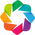

In [2]:
#Set up the bokeh extensions.
gv.extension('bokeh')
hv.extension('bokeh')
pn.extension()

## Import the Chemical data 

The first job of understanding chemical pollution is to get hold of the relevant data that we wish to analyse. For purposes of demonstration this notebook will only utilise 2 datasets, but the workflow presented here could be expanded to included other datasets as required. The two datasets used are as follows (dataset source details are provided in the data sources section above):

1) Air Quality data from the UK AURN network
2) Measurements of veterinary medications in water from the EA GCMS/LCMS dataset.

For simplicity of loading, the data used in this notebook has already been pre-processed and stored in parquet format for optimal loading. Otherwise the data has not been modified from the original source.

We also load in the a shapefile containing the UK boundaries for the Nomenclature of Territorial Units for Statistics (NUTS) level 1 regions. The NUTS regions are a classification system used in the European Union (EU) to define regions for statistical purposes and has been adopted by the UK for similar purposes in previous analyses. The level 1 regions are the highest sub-national level and represent large regions of the UK such as Scotland, Wales, North West England, etc. For computational efficiency we use the NUTS1 regions in this notebook, but the methods presented should work with any UK polygon shapefile. 

The code cell below loads in the data. 

In [3]:
#Set the location of the data.
data_path = "./data/"

#Read in the NUTS regions - NUTS3 in this example.
NUTS_gdf = gpd.read_file(data_path + 'NUTS_Level_1_January_2018_GCB_in_the_United_Kingdom_2022_-2753267915301604886.geojson')

#Read in the pre-processed data.
all_data       = pl.read_parquet(data_path + "EEX_all_data.parquet")
Sites_info_gdf = gpd.read_parquet(data_path + "Sites_info_gdf.parquet")

In order to set the NUTS regional data for the interactive dashboard we need to convert to a format the dashboard can use known as geoviews. 

In [4]:
NUTS_plt = gv.Polygons(NUTS_gdf, vdims=['nuts118cd','nuts118nm']).opts(color='black', fill_alpha=0, projection=ccrs.PlateCarree(),width=600,height=1000, tools=['hover', 'tap'], active_tools=['tap'], shared_axes=False)

Now that the data is loaded in we can take a quick look at the head of each dataframe to inspect the data structure and what we have in each dataset. Let's start with the air quality data. As out dataset contains both combined we need to filter on the air quality data only.

In [5]:
all_data.filter(pl.col('Measurement Category') == 'Air quality').head()

Pollutant,Concentration,Site_ID,Unit,Source,Site_Type,Date,Measurement Category,Longitude,Latitude
str,f64,str,str,str,str,"datetime[μs, UTC]",str,f64,f64
"""co""",1.033333,"""A3""","""mg/m3""","""aurn""","""Urban Traffic""",2000-01-01 00:00:00 UTC,"""Air quality""",-0.291853,51.37348
"""co""",0.783333,"""A3""","""mg/m3""","""aurn""","""Urban Traffic""",2000-01-02 00:00:00 UTC,"""Air quality""",-0.291853,51.37348
"""co""",0.454167,"""A3""","""mg/m3""","""aurn""","""Urban Traffic""",2000-01-03 00:00:00 UTC,"""Air quality""",-0.291853,51.37348
"""co""",1.004167,"""A3""","""mg/m3""","""aurn""","""Urban Traffic""",2000-01-04 00:00:00 UTC,"""Air quality""",-0.291853,51.37348
"""co""",0.665217,"""A3""","""mg/m3""","""aurn""","""Urban Traffic""",2000-01-05 00:00:00 UTC,"""Air quality""",-0.291853,51.37348


We can see that our dataset has the following columns:

1) Pollutant: The name of the chemical of being measured
2) Concentration: The concentration measured at the given location/time.
3) Site_ID: The unique identifier of the measurement site.
4) Unit: The unit of the concentration measurement.
5) Source: The source of the data.
6) Site_Type: The type of site being measured (E.g. Urban, Roadside, Rural)
7) Date: The date stamp of the measurement.
8) Measurement Category: The category of the measurement (E.g. Air Quality or Vet Med)
9) Longitude: The longitude of the measurement site.
10) Latitude: The Latitude of the measurement site.

Now do the same thing for the water quality data.

In [6]:
all_data.filter(pl.col('Measurement Category') == 'Vet meds').head()

Pollutant,Concentration,Site_ID,Unit,Source,Site_Type,Date,Measurement Category,Longitude,Latitude
str,f64,str,str,str,str,"datetime[μs, UTC]",str,f64,f64
"""Fipronil""",0.5,"""49000209""","""ug/l""","""GCMS""","""PE""",2016-08-10 12:00:00 UTC,"""Vet meds""",0.113421,53.57023
"""Fipronil""",0.5,"""G0006097""","""ug/l""","""GCMS""","""FZ""",2022-08-16 08:16:00 UTC,"""Vet meds""",-1.144528,50.887405
"""Fipronil""",0.5,"""MISCTL66""","""ug/l""","""GCMS""","""PE""",2011-05-22 02:35:00 UTC,"""Vet meds""",0.340553,52.214984
"""Fipronil""",0.5,"""MISCSK95""","""ug/l""","""GCMS""","""PE""",2011-07-09 23:10:00 UTC,"""Vet meds""",-0.65915,53.039711
"""Fipronil""",0.5,"""MISCSK95""","""ug/l""","""GCMS""","""PE""",2011-07-10 08:26:00 UTC,"""Vet meds""",-0.65915,53.039711


Now that we have inspected our data we can have a quick look at the NUTS1 regions to see what they look like.

<Axes: >

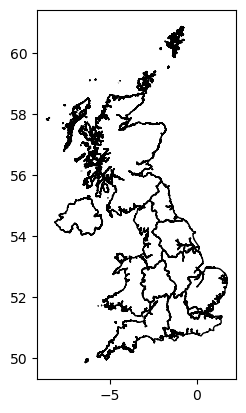

In [7]:
NUTS_gdf.plot(facecolor='none', edgecolor='black')

## Example Place Based Analysis.

Now that we have all our data loaded and we have a basic understanding of what it contains we can start thinking about asking hypothetical questions about the dataset. In this example we want to ask 'I lived in the North East of England from 2000 to 2025, what sort of pollution might I have been exposed to?'

First lets plot a close up of our region of interest and see how many measurement sites we have in that region. 

Text(0.5, 1.0, 'Measurement Sites in : North East (England)')

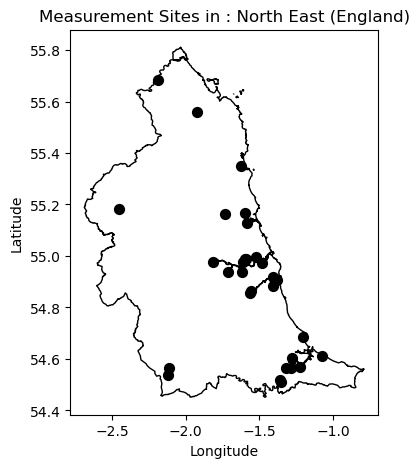

In [8]:
fig_NE, ax_NE = plt.subplots(figsize=(7, 5))

Sites_in_NE = Sites_info_gdf[['Site_ID', 'geometry']].loc[Sites_info_gdf.geometry.within(NUTS_gdf.geometry.iloc[0])]

#Polygon.
NUTS_gdf.iloc[[0]].plot(ax=ax_NE, facecolor='none', edgecolor='black')

#Filter the sites by just the current region.
#curr_rgn_sites = Sites_info_gdf.copy().loc[Sites_info_gdf.geometry.within(NUTS_gdf.iloc[[0]]['geometry'])]

# Overlay all points - dont distinguish by category.
ax_NE.scatter(Sites_in_NE.geometry.x,Sites_in_NE.geometry.y, s=50, color='black')

# Add labels and legend
ax_NE.set_xlabel('Longitude')
ax_NE.set_ylabel('Latitude')

#Set the title.
ax_NE.set_title('Measurement Sites in : ' + NUTS_gdf['nuts118nm'].iloc[0])

### Calculating summary of chemicals measured in the region of interest

Great so we now know that there are quite a few measurement sites in our region of interest however we now need to know what sort of chemicals are being measured at these sites and what sort of concentrations are being recorded by the various instruments. This requires a number of steps and interactions with the data in order to get the information we need. A summary of this workflow is as follows:

1) Use the boundary of the North East England region to filter the main dataset to only include measurement locations that fall within the boundary.
2) Further filter the data to remove any measurements that fall outside our date range of interest (2000-2025) - in this case this was handled in the pre-processing steps to ensure that only data from the 2000 to 2025 time period was include in the parquet file.
3) Filter the data to exclude any time stamps where there was not a concentration recorded or there is a negative value recorded which indicates missing data.
4) Calculate some simple summary statistics for each unique chemical measured in the region. These include the min, max and mean concentration, the number of sites measuring that chemical in the region, the date range covered by the measurements along with some contextual information on the data (source, unit, site type, etc).

As shown above this requires a number of different steps and complex operations on our dataset. The code that implements this is shown below. It has been setup to operate both within the notebook and the interactive dashboard environment. This function outputs a table containing the summary information for the given region. It takes a single input index representing the NUTS1 region to be analysed.

In [9]:
#Function to calculate a summary of the chemical data in a selected region. 
def calc_chem_summary(index):

    #Check for empty index if no selection yet made.
    if not index:
        out_col_list = ['Pollutant', 'Min Concentration', 'Max Concentration', 'Mean Concentration',
                        'Number of Sites', 'Measurement Category', 'Unit', 'Measurement Source',
                        'Sample Type', 'Date of first measurement', 'Date of last measurement']
        return hv.Table(pd.DataFrame(columns=out_col_list)).opts(width=1200, height=400)

    #If we have an index pick the geometry for filtering.
    selected_poly = NUTS_gdf.geometry.iloc[index[0]]

    # Filter sites in a specific polygon - this will be picked up using the index from the selector.
    Sites_in_poly = Sites_info_gdf['Site_ID'].loc[Sites_info_gdf.geometry.within(selected_poly)]

    #If no chemicals for given site pass back empty table.
    if Sites_in_poly.shape[0] == 0:
        out_col_list = ['Pollutant', 'Min Concentration', 'Max Concentration', 'Mean Concentration',
                        'Number of Sites', 'Measurement Category', 'Unit', 'Measurement Source',
                        'Sample Type', 'Date of first measurement', 'Date of last measurement']
        return hv.Table(pd.DataFrame(columns=out_col_list)).opts(width=1200, height=400)
    else:

        # Get the data.
        curr_rgn_data = all_data.filter((pl.col('Site_ID').is_in(Sites_in_poly) == True) & (pl.col('Concentration') > 0.0))

        #Get the required summary for the region.
        summ_rgn_data = curr_rgn_data.group_by('Pollutant').agg([
            pl.col('Concentration').min().alias('Min Concentration'),
            pl.col('Concentration').max().alias('Max Concentration'),
            pl.col('Concentration').mean().alias('Mean Concentration'),
            pl.col('Site_ID').n_unique().alias('Number of Sites'),
            pl.col('Measurement Category').unique().alias('Measurement Category'),
            pl.col('Unit').unique().alias('Unit'),
            pl.col('Source').unique().alias('Measurement Source'),
            pl.col('Site_Type').unique().alias('Sample Type'),
            pl.col('Date').min().alias('Date of first measurement'),
            pl.col('Date').max().alias('Date of last measurement')])

        #Format the correct output for columns where multiple categories are returned.
        summ_rgn_data = summ_rgn_data.with_columns(pl.col('Unit').list.join(',').alias('Unit'),
                                                   pl.col('Measurement Source').list.join(',').alias('Measurement Source'),
                                                   pl.col('Sample Type').list.join(',').alias('Sample Type'))


        #Return either as a holoviews table (if in a panel app) or a pandas dataframe (if in the notebook)
        if pn.state.served == True:
            summ_reg_table = hv.Table(summ_rgn_data.to_pandas()).opts(width=1200, height=400)
        else:
            summ_reg_table = summ_rgn_data.to_pandas()
        
        return summ_reg_table

So now that the analysis function is setup we can run it for our region of interest. In this case we want the North East of England so the first thing to do is find out what the index of this region is by inspecting the NUTS1 geospatial dataframe. 

In [10]:
#Print the NUTS1 dataframe.
NUTS_gdf

,OBJECTID,nuts118cd,nuts118nm,bng_e,bng_n,long,lat,GlobalID,geometry
0,1,UKC,North East (England),417313,600358,-1.728900,55.297031,b960bad6-f727-45f1-8319-75ad9d8aa82a,"MULTIPOLYGON (((-2.02941 55.76884, -2.0284 55...."
1,2,UKD,North West (England),350015,506280,-2.772370,54.449451,2543ce15-4a5d-42dd-8110-b5568bd7b560,"MULTIPOLYGON (((-2.67644 55.17304, -2.67769 55..."
2,3,UKE,Yorkshire and The Humber,446903,448736,-1.287120,53.932640,33a3ba53-4810-498e-9468-8eab341861a5,"MULTIPOLYGON (((-0.79223 54.55947, -0.78962 54..."
3,4,UKF,East Midlands (England),477660,322635,-0.849670,52.795719,683a7565-12d4-458d-8405-d95a4d94aaa6,"MULTIPOLYGON (((-0.30093 53.61639, -0.29824 53..."
4,5,UKG,West Midlands (England),386294,295477,-2.203580,52.556969,38472600-07d2-4115-80ad-fe314b8700a5,"POLYGON ((-1.95073 53.2119, -1.94881 53.21166,..."
5,6,UKH,East of England,571074,263229,0.504146,52.240669,6b764e5d-5e36-46fc-934d-b2e0ad39f826,"MULTIPOLYGON (((1.01574 52.97136, 1.01639 52.9..."
6,7,UKI,London,517516,178392,-0.308640,51.492271,7dad658c-1763-4cd7-8509-fc95a6807a08,"MULTIPOLYGON (((-0.09954 51.69111, -0.09478 51..."
7,8,UKJ,South East (England),470062,172924,-0.993110,51.450970,412463e0-a040-4186-873b-5bdaaf139ab2,"MULTIPOLYGON (((-0.68465 52.19634, -0.68124 52..."
8,9,UKK,South West (England),285015,102567,-3.633430,50.811192,cb520f76-4219-43f0-89f8-7cce740af115,"MULTIPOLYGON (((-1.75768 52.10316, -1.75598 52..."
9,10,UKL,Wales,263406,242881,-3.994160,52.067410,cc785f34-0719-42c4-82c0-198fe5297841,"MULTIPOLYGON (((-3.33533 53.35551, -3.32734 53..."


We can see that the North East region is the first one on the list and python counts the first element as index 0, therefore if we want the summary statistics we need to run the summary function with an input of zero. This needs to be supplied as a list object. As shown above there are 11 NUTS1 level regions in the UK so if we say wanted to run the same analysis for Wales we could just run the summary function with an input of 9. However we want the NE of England so lets proceed with calculating the summary for that.

In [11]:
calc_chem_summary([0])

,Pollutant,Min Concentration,Max Concentration,Mean Concentration,Number of Sites,Measurement Category,Unit,Measurement Source,Sample Type,Date of first measurement,Date of last measurement
0,pm10,0.282000,189.263000,16.889392,9,[Air quality],ug/m3,aurn,"Urban Traffic,Urban Background,Rural Backgroun...",2000-01-01 00:00:00+00:00,2025-11-02 00:00:00+00:00
1,nox,0.907510,693.946770,40.854868,11,[Air quality],ug/m3,aurn,"Urban Industrial,Urban Traffic,Urban Backgroun...",2000-01-01 00:00:00+00:00,2025-11-02 00:00:00+00:00
2,Clarithromycin,0.000900,0.008300,0.003469,2,[Vet meds],ug/l,LCMS,"CE,F6",2016-02-05 10:08:00+00:00,2023-12-01 10:07:00+00:00
3,pm2.5,0.083000,77.108000,8.691994,9,[Air quality],ug/m3,aurn,"Urban Traffic,Urban Background,Rural Background",2008-08-27 00:00:00+00:00,2025-11-02 00:00:00+00:00
4,no2,0.151990,144.704960,21.863488,11,[Air quality],ug/m3,aurn,"Urban Industrial,Urban Traffic,Urban Backgroun...",2000-01-01 00:00:00+00:00,2025-11-02 00:00:00+00:00
5,co,0.004167,2.241667,0.302103,4,[Air quality],mg/m3,aurn,"Urban Background,Suburban Background,Urban Tra...",2000-01-01 00:00:00+00:00,2012-12-29 00:00:00+00:00
6,Imidacloprid,0.001000,0.009500,0.003217,2,[Vet meds],ug/l,LCMS,"F6,CE",2016-02-05 10:08:00+00:00,2023-03-08 09:52:00+00:00
7,Fipronil,0.000200,0.203000,0.018651,17,[Vet meds],ug/l,"GCMS,LCMS","F6,CE,FA",2014-07-15 11:37:00+00:00,2024-06-21 09:59:00+00:00
8,no,0.036380,376.178170,12.419771,11,[Air quality],ug/m3,aurn,"Urban Industrial,Urban Traffic,Urban Backgroun...",2000-01-01 00:00:00+00:00,2025-11-02 00:00:00+00:00
9,Erythromycin,0.005000,0.005000,0.005000,1,[Vet meds],ug/l,LCMS,F6,2016-02-05 10:08:00+00:00,2017-10-13 13:09:00+00:00


### Chemical specific analysis and visualisation

As the above table shows the measurements sites in this region cover 11 different chemicals (4 Veterinary medicines and 7 air quality pollutants) with varying coverage across the region. E.g. Nitrogen Dioxide ($NO_2$) is measured at 14 different locations, Fipronil is measured at 17 locations, Carbon monoxide (CO) is only measured at 4 locations and Erythromycin is only measured at 1. Now we know what sort of chemicals are being measured we will want to look at specific chemicals on more detail. Depending on the chemical type (air quality or Vet Med) we will want to perform different types of analysis and visualisation to best represent the data. 

1) **Air Quality:** As there are a large number of locations measuring the air quality pollutants and there are not boundaries between these locations we can use simple spatial interpolation to estimate the distribution of the pollutant at the locations between the sites. This is done by creating a grid over the region and using simple linear interpolation (based on the values at the measurements site) to estimate the values at the grid points. This is done using mean exposure over the time period 2000 to 2025. We use the `griddata` function from the scipy package to do the interpolation. This function can also handle other forms of interpolation such as nearest neighbour or cubic but we have used linear here. We can then visualise the resultant spatial distribution on a map.

2) **Vet Meds:** As the Vet Meds data are represented as river samples we cannot use the same interpolation method due to constraints imposed by the river network. Therefore to understand the level of exposure for Vet Meds we simply just calculate the cumulative exposure (over the time period 2000 to 2025) at each site and color code the site marker based on the total level of exposure. This can then be visualised on a map. 

As with the calculation of the summary statistics the main dataset needs to be filtered based on the region and chemical of interest and then the various analytical methods need to be run to produce the desired outputs. The function below performs all the required processing, analysis and visualisation depending on the region and chemical type input into it. 

In [12]:
def plot_chem_sites(index, chem):

    #If no selection made display nothing.
    if not index:
        return gv.Polygons([], label='Please select a polygon to view data').opts(width=800,height=400, shared_axes=False)

    # If we have an index pick the geometry for filtering.
    selected_poly = NUTS_gdf.geometry.iloc[index[0]]
    Sites_in_poly = Sites_info_gdf[['Site_ID', 'geometry']].loc[Sites_info_gdf.geometry.within(selected_poly)]

    # Get the data.
    curr_rgn_data = all_data.filter(pl.col('Site_ID').is_in(Sites_in_poly['Site_ID']) == True).select(['Site_ID', 'Pollutant', 'Concentration','Measurement Category'])

    #If no data for the selected chemical return nothing.
    if curr_rgn_data.shape[0] == 0:
        if pn.state.served == True:
            return gv.Polygons([], label='No Data for selected chemical for this region.').opts(width=800,height=400, shared_axes=False)

    #Run a check on data type to plot, for vet meds plot locations and heatmap by samples, if AQ plot spatial distribution based on measurements.
    if curr_rgn_data.filter(pl.col('Pollutant') == chem).select('Measurement Category').unique().item() == 'Vet meds':

        count_df = curr_rgn_data.filter(pl.col('Pollutant') == chem).group_by('Site_ID').agg([pl.col('Concentration').mean().alias('Mean_Concentration')])

        curr_chem_pts = Sites_in_poly.merge(count_df.to_pandas(), on='Site_ID')

        #Now create the map.
        #If in panel app pass out interactive plot if in regular notebook pass out static plot.
        if pn.state.served == True:

            #Polygons first.
            curr_poly_layer = gv.Polygons(selected_poly).opts(color='black', fill_alpha=0, line_width=2, projection=ccrs.PlateCarree()) #Fill alpha sets fill to transparent.!
            #Create a heatmap of points based on number of samples.
            curr_pts_layer  = gv.Points(curr_chem_pts, vdims=['Site_ID','Mean_Concentration']).opts(
                                        size=10,
                                        color='Mean_Concentration',
                                        cmap='Viridis',
                                        tools=['hover'],
                                        width=600,
                                        height=400,
                                        title='Mean Concentration of ' + chem + '(2000-2025) for: ' + NUTS_gdf['nuts118nm'].iloc[index[0]]
                                        )

            #Create the combined plot and set the dimensions.
            curr_chem_plot  = (curr_poly_layer * curr_pts_layer).opts(width=800,height=400, shared_axes=False)

        else:

            plt.ioff() #Turns of interactive mode in pyplot to prevent render of blank plot when fig, ax called. 
            #Plot the data as a staic matplotlib plot if not in a panel app.        
            fig, ax = plt.subplots(figsize=(7, 5))

            #Polygon.
            NUTS_gdf.iloc[[index[0]]].plot(ax=ax, facecolor='none', edgecolor='black')

            # Overlay points
            points = ax.scatter(curr_chem_pts.geometry.x, curr_chem_pts.geometry.y, c=curr_chem_pts.Mean_Concentration, cmap='viridis', s=50, edgecolor='black', label='Measurement Sites')
            fig.colorbar(points, ax=ax, label='Mean Concentration')

            # Add labels and legend
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            #Set the title.
            ax.set_title('Mean Concentration of ' + chem + '(2000-2025) for: ' + NUTS_gdf['nuts118nm'].iloc[index[0]])

            curr_chem_plot = fig



    elif curr_rgn_data.filter(pl.col('Pollutant') == chem).select('Measurement Category').unique().item() == 'Air quality':

        #Calculate the total exposure to the air pollutant.
        total_exp_df  = curr_rgn_data.filter(pl.col('Pollutant') == chem).group_by('Site_ID').agg([pl.col('Concentration').mean().alias('Mean Exposure')])
        curr_chem_pts = Sites_in_poly.merge(total_exp_df.to_pandas(), on='Site_ID')
        #Filter on where we have data.
        curr_chem_pts = curr_chem_pts.loc[(curr_chem_pts['Mean Exposure'] > 0.0) & (curr_chem_pts['Mean Exposure'].isnull() == False)]

        # KDE heatmap
        x = curr_chem_pts.geometry.x
        y = curr_chem_pts.geometry.y
        weights = curr_chem_pts['Mean Exposure'].values

        # Grid over polygon bounds - this will be used to model the exposure across the region on.
        xmin, ymin, xmax, ymax = selected_poly.bounds
        xx, yy    = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] #Meshgrid for modelling the KDE on

        # Quick check to see if we have enough data to fit the interpolation - if not just pass out zeros.
        if len(weights) >= 4:
          density = griddata(np.column_stack([x,y]), weights, (xx, yy), method='linear')
        else:
          density = np.zeros(xx.shape)

        #Depending on if running in a notebook render as either holoviews (panel app) or matplotlib (notebook).
        if pn.state.served == True:

            # Holoviews Image
            AQ_heatmap = hv.QuadMesh((xx,yy,density)).opts(cmap='Viridis',alpha=0.6,tools=['hover'],line_color=None,line_width=1,
                                                        width=600,
                                                        height=400,title='Air pollutant exposure: ' + chem)

            #Also add the locations of the sampling points for the current AQ pollutant.
            curr_pts_layer = gv.Points(curr_chem_pts, vdims=['Site_ID']).opts(
                size=10,
                color='Black',
                tools=['hover'],
                width=600,
                height=400,
                title='Sample Density Heatmap'
            )


            #Polygon layer.
            curr_poly_layer = gv.Polygons(selected_poly).opts(color='black', fill_alpha=0, line_width=2,projection=ccrs.PlateCarree())  # Fill alpha sets fill to transparent.!

            #Produce the final plot.
            curr_chem_plot = (curr_poly_layer * AQ_heatmap * curr_pts_layer).opts(width=600, height=400, shared_axes=False)

        else:

            plt.ioff() #Turns of interactive mode in pyplot to prevent render of blank plot when fig, ax called. 
            fig, ax = plt.subplots(figsize=(7, 5))

            #Plot the data as a staic matplotlib plot if not in a panel app.
            mesh = ax.pcolormesh(xx, yy, density, cmap='viridis', shading='auto')
            fig.colorbar(mesh, ax=ax, label='Total Concentration')

            #Polygon.
            NUTS_gdf.iloc[[index[0]]].plot(ax=ax, facecolor='none', edgecolor='black')

            # Overlay points
            ax.scatter(curr_chem_pts.geometry.x, curr_chem_pts.geometry.y, color='black', s=50, edgecolor='black', label='Measurement Sites')

            # Add labels and legend
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            #Set the title.
            ax.set_title('Air pollutant exposure: ' + chem + ' for: ' + NUTS_gdf['nuts118nm'].iloc[index[0]])

            curr_chem_plot = fig

    return curr_chem_plot

Say we want to see the exposure to Nitrogen Dioxide in the NE of England from 2000 to 2025 we can call the above function as follows and view the resultant map.

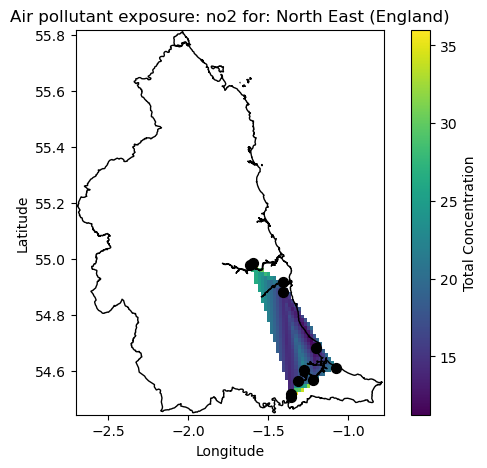

In [13]:
plot_chem_sites([0], 'no2')

As we can see from the map the measurement locations are centred around the main urban areas of Newcastle, Sunderland and Kingston upon Hull where mean exposure if approaching 30 ug/m3 around the regions. We do however see elevated levels of exposure in the intermediate locations between the major cities. It should be noted that this is only a simple interpolation for purposes of method demonstrations and more detailed and advanced analytical approaches will be needed to truly investigate the data.

Now lets have a look at what we get it focussing on the Veterinary medicines, in this case the common flea treatment of Fipronil which is potentially harmful to aquatic organisms. We can use the same function again to look at this. 

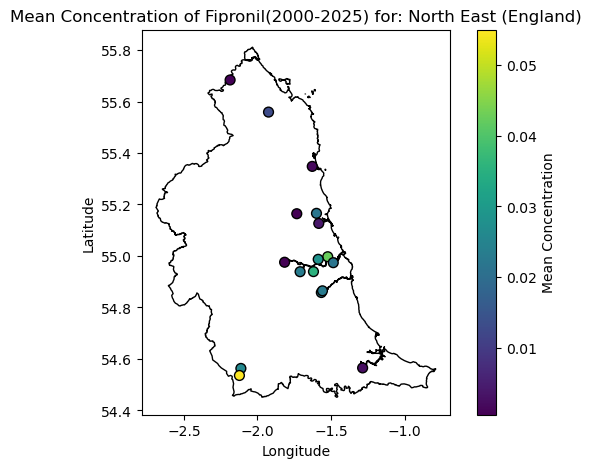

In [14]:
plot_chem_sites([0], 'Fipronil')

## Breaking down the barriers to running complex analysis

As shown above the methods presented provide us with a good starting point to begin to understand what sort of chemical pollutants we would be exposed for a particular region over a particular time period. It has also been demonstrated that you can change the place or chemical of interest and re-run the analysis in fairly few steps but this does require some coding experience and understanding of the python coding language. In order to make the workflow more accessible to non-coders and allow interactive exploration of the dataset the notebook has been setup to run as an interactive dashboard app using the panel package. This code in the notebook has been setup so that it can run in either interactive dashboard or notebook mode with no changes. The code cell below shows the code that runs the app as a dashboard. For clarity this code has been hidden by default but can be viewed by expanding the drop down. 

In [15]:
#Only run this cell if in a panel app.
if pn.state.served == True:

    #Now set up the notebook to run interactively if served via panel.
    #Create a selection stream - this will be used to pick up the chemical data for each region.
    selection_summary = Selection1D(source=NUTS_plt)

    #Create a panel widget that holds the list of available chemicals.
    chem_options = pn.widgets.Select(name='List of Chemicals', options=[])

    #Callback function to update the widget.
    #Need to se watch to true here as panel is updating the widget.
    @pn.depends(selection_summary.param.index, watch=True)
    def update_chem_options(index):

        if index:
            selected_poly        = NUTS_gdf.geometry.iloc[index[0]]
            Sites_in_poly        = Sites_info_gdf['Site_ID'].loc[Sites_info_gdf.geometry.within(selected_poly)]
            if Sites_in_poly.shape[0] == 0:
                chem_options.options = ['No Chemicals Found']
                chem_options.value = 'No Chemicals Found'
            else:
                chem_options.options = all_data.filter(pl.col('Site_ID').is_in(Sites_in_poly) == True).get_column('Pollutant').unique().to_list()
                chem_options.value   = all_data.filter(pl.col('Site_ID').is_in(Sites_in_poly) == True).get_column('Pollutant').unique().to_list()[0]
        else:
            chem_options.options = ['No Chemicals Found']
            chem_options.value = 'No Chemicals Found'

    #Now need to set up reactive versions of the above functions to work in panel.
    chem_summary_reactive = pn.bind(calc_chem_summary, selection_summary.param.index)
    chem_plot_reactive    = pn.bind(plot_chem_sites, selection_summary.param.index, chem_options.param.value)

    #Create the panel layout and serve.
    dashboard = pn.Row(pn.Column(NUTS_plt) , pn.Column(pn.panel(chem_summary_reactive), pn.panel(chem_options), pn.panel(chem_plot_reactive)))
    dashboard.servable()


### Running the app in dashboard mode

To run the notebook as an interactive dashboard simply navigate to the folder containing the notebook in a terminal window and serve the notebook as a Bokeh app as the command line:

`bokeh serve --show EEX_placebased_exposure_notebook.ipynb`

Although this step requires some command line experience the result is a fully interactive dashboard that can be accessed from a web browser. 

## Summary

In summary this notebook has presented a simple demonstration of how to approach the challenge of understanding what sort of chemical pollution you might be exposed to in a particular location. The methods demonstrated here are not meant to be exhaustive and are setup as a starting point on which users can build upon to create a more detailed analysis for their own datasets. As a reminder this notebook demonstrated the following:

- Loading in a large dataset containing both air quality and and Veterinary medicine pollutant concentrations at various locations around the UK
- Loading in a shapefile containing the UK NUTS1 regions to represent places of interest.
- Filtering the main dataset based on a region of interest and calculating summary statistics for all chemicals measured in that region.
- Performing chemical specific analysis and visualisation depending on the chemical type (air quality or Vet Med).
- Running the notebook as an interactive dashboard to allow non-coders to explore the datasets and also visualise the results.


The methods presented here are expected to be updated as the work on the EEX Hub develops further and will ultimately be utilised as tools to help realise the vision of the Hub. 